<center> <h1> Amazon Reviews</h1>
 <h2> Sentimetal Analysis with Machine Learning </h2> </center>

<h3> Dataset</h3>

The dataset contain <code>polarity</code>, <code>title</code> and <code>text</code>. These 3 columns in them, correspond to class index (1 or 2), review title and review text. 
<ul>
    <li>polarity - 1 for negative and 2 for positive</li>
    <li>title - review heading</li>
    <li>text - review body</li>
</ul>

The dataset is avaible <A href="https://www.kaggle.com/datasets/kritanjalijain/amazon-reviews"> here.</A>

<h2> Objectives </h2>

<ul>
    <li>Processing data.</li>
    <li>Fitting and training two machine learning models. </li>
</ul>

<h2> Outline</h2>


<ol>
    <li>Load data.</li>
    <li>Clean and processing data.</li>
    <li>Exploration Data Analysis. (EDA).</li>
    <li>Feature extraction.</li>
    <li>Train-Test Split.</li>
    <li>Fitting and train ML models.</li>
    <li>Predicctions.</li>
</ol>

# Load data

<h2> Libraries </h2>

In [6]:
#!pip install contractions==0.1.72

In [7]:
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from termcolor import colored

from collections import Counter
import re
import nltk
# nltk.download('omw-1.4')
# nltk.download('wordnet2022')
#nlp = load('en_core_web_sm')
from nltk.tokenize import RegexpTokenizer
#import contractions

from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
# from nltk.stem import WordNetLemmatizer, PorterStemmer
# porter = PorterStemmer()
# lem = WordNetLemmatizer()
# nltk.download('punkt')

from nltk.stem import WordNetLemmatizer, SnowballStemmer
stemmer = SnowballStemmer("english")

from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score, average_precision_score, precision_recall_curve
from sklearn.metrics import accuracy_score, classification_report

import warnings 
warnings.filterwarnings("ignore")

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
[nltk_data] Error loading wordnet: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


In [8]:
! cp -rf /usr/share/nltk_data/corpora/wordnet2022 /usr/share/nltk_data/corpora/wordnet # temp fix for lookup error.

cp: cannot stat '/usr/share/nltk_data/corpora/wordnet2022': No such file or directory


In [9]:
df = pd.read_csv('/kaggle/input/amazon-reviews/train.csv',  header=None)
df.columns = ['Rating', 'Title', 'Review']
df.head(10)

,Rating,Title,Review
0,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,2,Amazing!,This soundtrack is my favorite music of all ti...
3,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
4,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."
5,2,an absolute masterpiece,I am quite sure any of you actually taking the...
6,1,Buyer beware,"This is a self-published book, and if you want..."
7,2,Glorious story,I loved Whisper of the wicked saints. The stor...
8,2,A FIVE STAR BOOK,I just finished reading Whisper of the Wicked ...
9,2,Whispers of the Wicked Saints,This was a easy to read book that made me want...


In [10]:
df.shape

(3600000, 3)

> <b>Inference</b>: In order to save time and resources, only 2.5% of the data set will be used.

# Clean and Processing data

In [11]:
# Random Sample Function 
def random_sample(data):
    return data.sample(frac = 0.025)

In [12]:
## Check changes
df = random_sample(df)
df.shape

(90000, 3)

In [13]:
df = df[['Rating', 'Review']].reset_index(drop=True)

In [14]:
## Set labels to 0 and 1
def decrease_label_by_one(label):
    return label - 1

df['Rating'] = df['Rating'].apply(decrease_label_by_one)

In [15]:
## Check changes
df.head()

,Rating,Review
0,1,This book was required reading in High school ...
1,0,2 of my friends bought this thing:--One of the...
2,1,Alive is the true story of the Uruguayan rugby...
3,0,"Scandalous though it may have been in the 50s,..."
4,1,"I had purchased a different phone, which I ret..."


In [16]:
## Count ratings
df.Rating.value_counts(normalize = True)

0    0.500956
1    0.499044
Name: Rating, dtype: float64

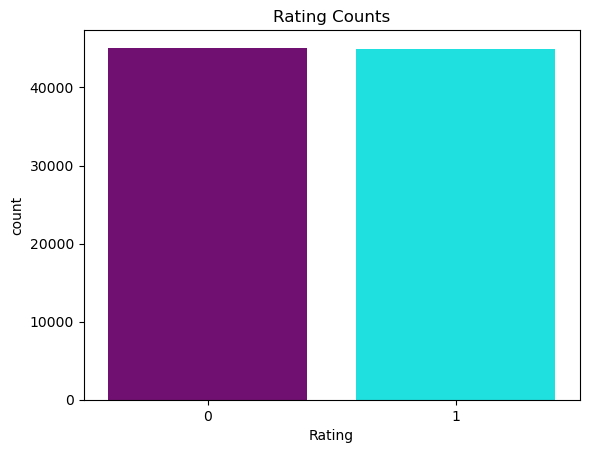

In [17]:
color_palette = ['purple', 'cyan']
sns.set_palette(color_palette) 
sns.countplot(x=df['Rating'])

plt.title('Rating Counts')
plt.show()

> <b> Inference</b>: The data are balanced

In [18]:
## Count null values
df.isnull().sum()

Rating    0
Review    0
dtype: int64

> <b> Inference</b>: There aren't null values.

<h2> Processing data</h2>

Code Explanation: 
<ol>
    <li>Text Cleaning:</li>
        <ul>
            <li>Uses regular expressions to remove non-alphanumeric and non-numeric characters from the text.</li>
            <li>Utilizes the contractions library to expand contractions and replace them with their full forms.</li>
            <li>Removes numeric digits from the text.</li>
            <li>Replaces the string " s " with a blank space.</li>
            <li>Converts the entire text to lowercase.</li>
        </ul>
    <li>Stopword Removal:</li>
        <ul>
            <li>Tokenizes the text using the nltk.word_tokenize function to split it into individual words.</li>
            <li>Filters out words from the text to remove those that are present in the set of stopwords (common words that don't contribute much meaning to the analysis).</li>
        </ul>
    <li>Text Normalization:</li>
        <ul>
            <li>Utilizes a stemmer (in this case, the SnowballStemmer) to reduce words to their base or root form.</li>
            <li>Applies the stemmer to each word in the tokenized text.</li>
            <li>Joins the normalized words back together into a text string.</li>
          </ul>
</ol>

In [19]:
def preprocess_text(text):
    # Text clean
    text = re.sub(r'[\W_]+', ' ', contractions.fix(re.sub(r'\d+', '', text.replace(' s ', ' ')))).lower()

    # Stopword removal
    tokens = nltk.word_tokenize(text)
    text = " ".join([token for token in tokens if token not in stop_words])

    # Data Normalization
    normalized_text = [stemmer.stem(word) for word in text.split()]
    text = ' '.join(normalized_text)

    return text

In [ ]:
## Cleaning and processing on the Review variable
df['Review'] = df['Review'].apply(preprocess_text)

In [ ]:
df.head(10)

# Exploration Data Analysis (EDA)

In [ ]:
## Frequency Words
words = Counter(' '.join(df['Review'].to_list()).split())
Frequency_words = pd.DataFrame([words]).transpose().reset_index().rename(columns = {'index': 'Words', 0:'Frequency' })
Frequency_words = Frequency_words.sort_values('Frequency',ascending=False).reset_index(drop='index').reset_index().rename(columns={'index':'Rank'})
Frequency_words['Rank'] = Frequency_words['Rank'].apply(lambda x : x+1)
Frequency_words.head(20)

In [ ]:
Top10 = Frequency_words[['Words','Frequency']].head(10)
Top10.plot(x="Words", y="Frequency", kind='bar',  figsize=(15,7), color = 'purple')
plt.title("Most Frequently occuring words - Top 20")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()

In [ ]:
from wordcloud import WordCloud
#  WordCloud chart 

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'black',
        max_words = 350,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()

# print wordcloud
show_wordcloud(df["Review"])

# Feature Extraction

<p>The code snippet defines a <code>TfidfVectorizer</code> object named Tf with the following configuration:
<ul>
    <li><code>max_features</code>: The maximum number of features (words or character n-grams) to consider in the vocabulary. In this case, it is set to 20,000.</li>
    <li><code>ngram_range</code>: Specifies the range of n-grams to generate. The value (1, 3) indicates that both unigrams (individual characters) and n-grams of length 2 and 3 (character sequences) will be included.</li>
    <li><code>analyzer</code>: Specifies whether the vectorizer should treat the input as words or characters. Here, 'char' indicates that character-level n-grams will be used.</li>
<ul>

In [ ]:
Tf = TfidfVectorizer(max_features = 20000, ngram_range=(1,3), analyzer ='char')
Tf

In [ ]:
X = Tf.fit_transform(df['Review'])
y = df['Rating']

# Train-Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

# Fitting and train ML models

<h2> Train a logistic Regression Model on the Training Data</h2>

In [ ]:
lr = LogisticRegression(max_iter=5000)

# Define the preprocessing steps for numeric features
lr.fit(X_train, y_train)

# Evaluate the model on the testing data
lr_preds = lr.predict(X_test)

# Evaluate the accuracy of the model
lr_accuracy = accuracy_score(y_test, lr_preds)*100
print(f"Accuracy of Linear Regression Model: {lr_accuracy:.2f}%")

<h2> Train a SVC Linear Model on the Training Data</h2>

In [ ]:
svm = LinearSVC()

# Define the preprocessing steps for numeric features
svm.fit(X_train, y_train)

# Predict the ratings for the test set
svm_preds = svm.predict(X_test)

# Evaluate the accuracy of the model
svm_accuracy = accuracy_score(y_test, svm_preds)*100
print(f"Accuracy of SVM Model: {svm_accuracy:.2f}%")

In [ ]:
models = ['Linear Regression', 'SVM']
accuracy = [lr_accuracy, svm_accuracy]
plt.bar(models, accuracy)
plt.title('Accuracy')
plt.ylim(0, 100)
plt.show()

In [ ]:
def plot_precision_recall_curve(y_true, y_scores, model_name):
    average_precision = average_precision_score(y_true, y_scores)
    precision, recall, _ = precision_recall_curve(y_true, y_scores)

    plt.figure(figsize=(10, 7))
    plt.plot(recall, precision, lw=2, color='navy', label='Precision-Recall Curve')
    plt.fill_between(recall, precision, alpha=0.2, color='navy')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(f'Precision-Recall Curve of {model_name}: AP = {average_precision:.2f}')
    plt.legend(loc="lower left")
    plt.show()

In [ ]:
## Precision-Recall Curve of LR model
plot_precision_recall_curve(y_test, lr_preds, 'Logistic Regression Model')

In [ ]:
# Precision-Recall Curve of SVM model
plot_precision_recall_curve(y_test, svm_preds, 'Precision-Recall Curve of SVM model')

In [ ]:
## Classification report
print(classification_report(y_test,lr_preds))
print(classification_report(y_test,svm_preds))

> <b>Inference</b>: Based on the results of the provided classification reports, we can see that both the Logistic Regression (LR) model and the Support Vector Machines (SVM) model have very similar results in terms of accuracy, recall and F1 score. Both models have a precision, recall and F1 score around 0.81 for both classes (0 and 1), as well as for macro precision, macro recall and F1 macro score.

# Predicctions

In [ ]:
def predict_sentiment(comment, vectorizer, model):
    vec = vectorizer.transform([comment])
    prediction = model.predict(vec)
    
    if prediction == 0:
        print(colored("Negative", "red"))
    else:
        print(colored("Positive", "blue"))

In [ ]:
x = "Lousy product. The quality is very low."
predict_sentiment(x, Tf, svm)

In [ ]:
x1 = "The quality is bad."
predict_sentiment(x1, Tf, lr)

In [ ]:
x2 = "The book is awesome."
predict_sentiment(x2, Tf, svm)